In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
ds = pd.read_csv('./titanic.csv')

print ds.columns
ds.head(n=10)

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
mean_Age = ds['Age'].mean()
ds['Age'] = ds['Age'].fillna(int(mean_Age))

sex_mapping = {
    'male': 0,
    'female': 1
}

sex = ds['Sex'].values
print sex.shape
quant_sex = np.zeros(sex.shape)

for ix in range(quant_sex.shape[0]):
    quant_sex[ix] = sex_mapping[sex[ix]]


(891,)


In [4]:

data = np.asarray([ds['Age'], ds['Pclass'], ds['SibSp'],
        ds['Parch'], ds['Fare'], quant_sex,
        ds['Survived']]).astype("float").T
Y = ds['Survived'].values
cols = ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex', 'Survived']
print data[0]
# ds.head(n=1)

[ 22.     3.     1.     0.     7.25   0.     0.  ]


In [5]:

def data_split(dataset, col_id, value):
    data_right = []
    data_left = []
    
    # send greater values to right and smaller or equal to left
    for ix in range(dataset.shape[0]):
        if dataset[ix, col_id] <= value:
            data_left.append(dataset[ix, :])
        else:
            data_right.append(dataset[ix, :])
    return np.asarray(data_right), np.asarray(data_left)

In [6]:
x, y = data_split(data[:100], 1, 1)
print x.shape
print y.shape

print cols
print x[:, -1].mean()
print y[:, -1].mean()

print '-----------------'

p1 = entropy(x, -1)
i1 = information_gain(p1)

p2 = entropy(y, -1)
i2 = information_gain(p2)

print i1, i2
print i1 + i2

(79, 7)
(21, 7)
['Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex', 'Survived']
0.392405063291
0.47619047619
-----------------


NameError: name 'entropy' is not defined

In [7]:
def entropy(dataset, col=-1):
    if dataset.shape[0] == 0:
        return 0
    p = dataset[:, col].mean()
    if p == 1 or p == 0:
        return 0.0
    ent = (-1.0 * p * np.log2(p)) + (-1.0 * (1.0 - p) * np.log2(1.0 - p))
    return ent
    
def information_gain(parent_set, child_1, child_2):
    # print parent_set.shape, child_1.shape, child_2.shape
    ent_p = entropy(parent_set)
    ent_c1 = entropy(child_1)
    ent_c2 = entropy(child_2)
    
    f = float(child_1.shape[0])/parent_set.shape[0]
    Ig = ent_p - (f*ent_c1 + (1-f)*ent_c2)
    return Ig

In [8]:
INF = 100000
class DT:
    def __init__(self, depth=0, max_depth=10):
        self.left = None
        self.right = None
        self.col_id = None
        self.value = None
        self.depth = depth
        self.max_depth = max_depth
        self.n_survival = None
        self.n_death = None
    
    def get_best_gain(self, dataset):
        
        n_cols = 6 # number of columns in data
        all_gains = []
        
        self.n_survival = dataset[:, -1].sum()
        self.n_death = dataset.shape[0] - self.n_survival
        
        for cx in range(n_cols):
            mean_val_cx = dataset[:, cx].mean()
            right, left = data_split(dataset, cx, mean_val_cx)
            
            total_gain = information_gain(dataset, right, left)
            all_gains.append(total_gain)
            
        self.col_id = np.asarray(all_gains).argmax()
        self.value = dataset[:, self.col_id].mean()
        
        data_right, data_left = data_split(dataset, self.col_id, self.value)
        
        if data_left.shape[0] > 0 and self.depth < self.max_depth:
            self.left = DT(depth=self.depth+1, max_depth=self.max_depth)
            self.left.get_best_gain(data_left)
            
        if data_right.shape[0] > 0 and self.depth < self.max_depth:
            self.right = DT(depth=self.depth+1, max_depth=self.max_depth)
            self.right.get_best_gain(data_right)
        return
    
    def predict(self, example):
        exp_val = example[self.col_id]
        # print self.n_survival, self.n_death, self.depth
        # print self.col_id, exp_val, self.value, '-------------'
        if exp_val <= self.value:
            if not self.left == None:
                # print 'going left'
                return self.left.predict(example)
            else:
                # print 'end left'
                return self.decide()
        else:
            if not self.right == None:
                # print 'going right'
                return self.right.predict(example)
            else:
                # print 'end right'
                return self.decide()
    
    def decide(self):
        # print self.depth
        if self.n_survival >= self.n_death:
            return 1
        else:
            return 0

In [9]:

# dt = DT(max_depth=10)
# dt.get_best_gain(data)

In [10]:
split = int(0.80 * data.shape[0])
X_train = data[:split, :]
y_train = data[:split, -1]
y_tr_pred = np.zeros(y_train.shape)

X_test = data[split:, :-1]
y_test = data[split:, -1]

print X_train.shape, X_test.shape, y_test.shape

y_pred = np.zeros(y_test.shape)

all_depths = range(2, 16)
acc_train = []
acc_test = []

for dpx in all_depths:
    dt = DT(max_depth=dpx)
    dt.get_best_gain(X_train)

    correct = 0
    cr_train = 0

    for yx in range(y_train.shape[0]):
        y_tr_pred[yx] = dt.predict(X_train[yx, :-1])
        if y_tr_pred[yx] == y_train[yx]:
            cr_train += 1

    for yx in range(y_pred.shape[0]):
        y_pred[yx] = dt.predict(X_test[yx, :])
        if y_pred[yx] == y_test[yx]:
            correct += 1
    acc_train.append(float(cr_train)/y_train.shape[0])
    acc_test.append(float(correct)/y_pred.shape[0])

    # print "Training Accuracy:", str(100*float(cr_train)/y_train.shape[0]) + "%"
    # print "Test Accuracy:", str(100*float(correct)/y_pred.shape[0]) + "%"
acc_train = np.asarray(acc_train)
acc_test = np.asarray(acc_test)

print acc_train.shape
print acc_test.shape

(712, 7) (179, 6) (179,)
(14,)
(14,)


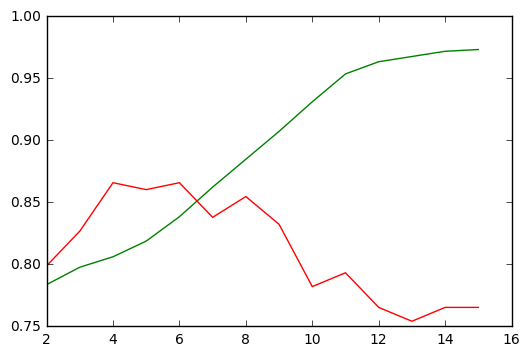

In [11]:
plt.figure(0)
plt.plot(all_depths, acc_train, 'g')
plt.plot(all_depths, acc_test, 'r')

plt.show()

In [12]:

print y_pred[:10]
print y_test[:10]

[ 0.  1.  0.  0.  1.  1.  0.  0.  1.  0.]
[ 1.  0.  0.  0.  1.  1.  0.  0.  1.  0.]


In [13]:
n = 300
ex = data[n, :-1]
print ex, data[n, -1]
print cols
dt.predict(ex)

[ 29.     3.     0.     0.     7.75   1.  ] 1.0
['Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex', 'Survived']


1